<a href="https://colab.research.google.com/github/Kalisa21/SmartCiti/blob/main/TrafficSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
file_path = "/content/Traffic.csv"
df = pd.read_csv(file_path)

# Encode categorical target variable
label_encoder = LabelEncoder()
df['Traffic Situation'] = label_encoder.fit_transform(df['Traffic Situation'])

# Drop non-numeric and redundant columns
df = df.drop(columns=['Time', 'Date', 'Day of the week'])

# Separate features and target
X = df.drop(columns=['Traffic Situation'])
y = df['Traffic Situation']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def evaluate_model(y_test, y_pred_classes, title="Confusion Matrix"):
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


In [3]:
# Function to plot loss curves
def plot_loss_curves(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6305 - loss: 1.3650 - val_accuracy: 0.8742 - val_loss: 0.7231
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8403 - loss: 0.7088 - val_accuracy: 0.8674 - val_loss: 0.5773
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8692 - loss: 0.5614 - val_accuracy: 0.8792 - val_loss: 0.4725
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8794 - loss: 0.4958 - val_accuracy: 0.8876 - val_loss: 0.4591
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8767 - loss: 0.4549 - val_accuracy: 0.9060 - val_loss: 0.3960
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8937 - loss: 0.4111 - val_accuracy: 0.9060 - val_loss: 0.3895
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8881 - loss: 0.4193 - val_accuracy: 0.8943 - val_loss: 0.3857
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.4043 - val_accuracy: 0.8943

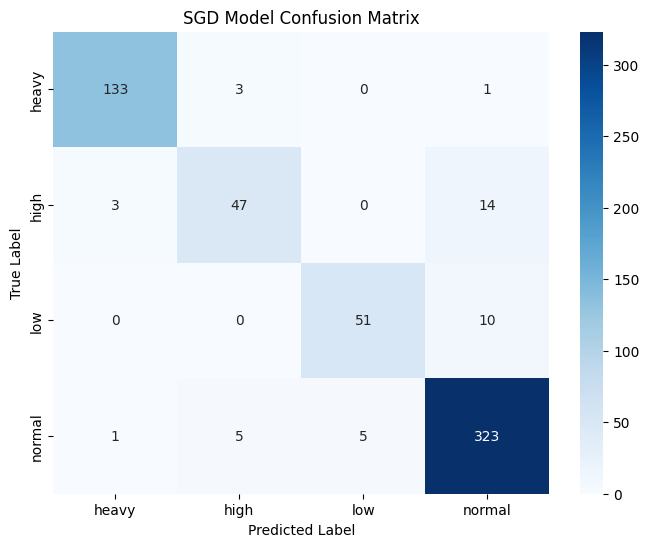

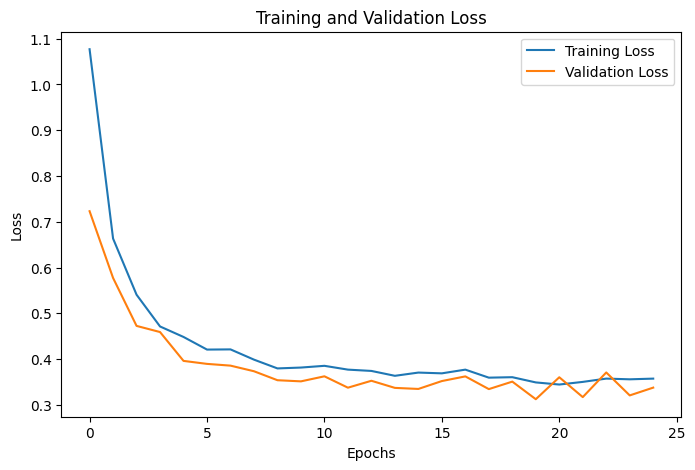

In [4]:

# Neural Network with SGD
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stopping], verbose=1)
y_pred = model.predict(X_test).argmax(axis=1)

evaluate_model(y_test, y_pred, title="SGD Model Confusion Matrix")

plot_loss_curves(history, "Loss Curve - SGD Model")


In [5]:

import numpy as np

# Function to make predictions from user input
def predict_traffic():
    print("\nEnter traffic data for prediction:")

    # User input for vehicle counts
    car_count = int(input("Enter number of Cars: "))
    bike_count = int(input("Enter number of Bikes: "))
    bus_count = int(input("Enter number of Buses: "))
    truck_count = int(input("Enter number of Trucks: "))

    # Compute the total vehicle count
    total_count = car_count + bike_count + bus_count + truck_count

    # Create input array
    input_data = np.array([[car_count, bike_count, bus_count, truck_count, total_count]])

    # Standardize input using the same scaler used in training
    input_data_scaled = scaler.transform(input_data)

    # Predict the traffic situation
    predicted_class = model.predict(input_data_scaled).argmax(axis=1)[0]

    # Get the corresponding traffic situation label
    traffic_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"\n🔹 **Predicted Traffic Situation: {traffic_label}** 🔹")

# Call the function to make predictions
predict_traffic()


Enter traffic data for prediction:
Enter number of Cars: 4
Enter number of Bikes: 7888
Enter number of Buses: 45
Enter number of Trucks: 78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

🔹 **Predicted Traffic Situation: heavy** 🔹


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
